# The pythonic approach to geografical information system

## Overview

* Import raster data format
* Plot raster data
* Change coordinate reference system
* Reproject raster data
* Import and exploring vector data formats
* Filter data
* Plotting vector data
* Polygons
* Data analysis

In [30]:
import rasterio                  # I/O raster data (netcdf, height, geotiff, ...)
import rasterio.warp             # Reproject raster samples
import fiona                     # I/O vector data (shape, geojson, ...)
import pyproj                    # Change coordinate reference system

import numpy as np               # numerical array manipulation
import matplotlib.pyplot as plt  # plotting tools
%matplotlib inline

import warnings                  # ignore annoying warnings
warnings.filterwarnings("ignore")

## Import raster files using `rasterio`

Read more on:
https://github.com/mapbox/rasterio

In [47]:
# Map of Norway
with rasterio.open("nc/etopo180.nc", "r") as src_nc:

    left, bottom, right, top = src_nc.bounds
    height, width = src_nc.shape

    # raster information
    print("left: %s, right: %s, bottom: %s, top: %s" % (left, right, bottom, top))
    print("height: %s, width: %s" % (height, width))
    
    # 1D vectors
    x_1d = np.linspace(left, right, width)
    y_1d = np.linspace(top, bottom, height)

    # 2D vectors trough meshing
    x, y = np.meshgrid(x_1d, y_1d)

    z = src_nc.read()[0]

    print("shapes:", x.shape, y.shape, z.shape)

left: 2.9916666666666667, right: 32.00833333333333, bottom: 56.991666666666674, top: 71.50833333333334
height: 871, width: 1741
shapes: (871, 1741) (871, 1741) (871, 1741)


## Plot data using the `matplotlib` library

Read more on:
http://matplotlib.org/

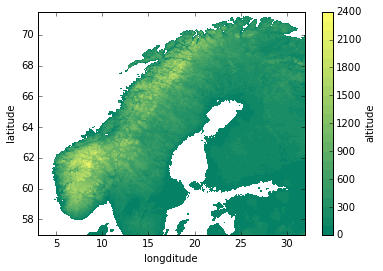

In [48]:
# altitude colors
colors = range(0, 2500, 100)

# plot in summer greens
plt.contourf(x, y, z, colors, cmap="summer")

# labels and colorbar
plt.xlabel("longditude")
plt.ylabel("latitude")
plt.colorbar().set_label("altitude")

## Processing data with `numpy`

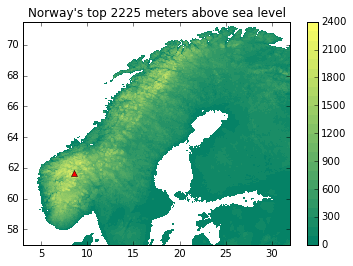

In [49]:
index = np.argwhere(z == np.max(z))
i, j = index.T

x_max = x[i, j]
y_max = y[i, j]
z_max = z[i, j]

plt.contourf(x, y, z, colors, cmap="summer")
plt.colorbar()

plt.plot(x_max, y_max, "r^")
plt.title("Norway's top %d meters above sea level" % z_max)

## Changing coordinate reference system with `pyproj`

Read more on:
http://jswhit.github.io/pyproj/

In [50]:
print("coordinate reference system:", src_nc.crs)
# no info typically means WGS84/EPSG:4326

wgs84 = pyproj.Proj(init="epsg:4326")
utm33n = pyproj.Proj(init="epsg:32633")

x_utm33n, y_utm33n, z_utm33n = pyproj.transform(wgs84, utm33n, x, y, z)

coordinate reference system: {}


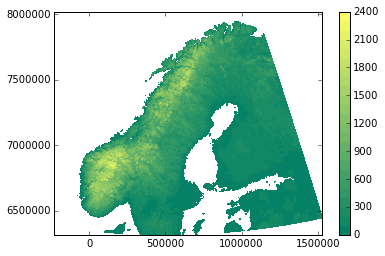

In [51]:
plt.contourf(x_utm33n, y_utm33n, z_utm33n, colors, cmap="summer")
plt.colorbar()

## Zoom alternative 1: Subset data

In [52]:
# lon/lat bounding box for Telemark
left, right, bottom, top = 6.9, 10.0, 58.6, 60.2

# closest indices on mesh
i_left   = np.argmin( (x_1d - left)**2   )
i_right  = np.argmin( (x_1d - right)**2  )
i_top    = np.argmin( (y_1d - top)**2    )
i_bottom = np.argmin( (y_1d - bottom)**2 )

print("Bounding box on grid:")
print(x_1d[i_left], x_1d[i_right], y_1d[i_bottom], y_1d[i_top])

Bounding box on grid:
6.89390804598 9.99568965517 58.5935057471 60.1953448276


In [53]:
# subset to box thorugh slicing
x_telemark = x[i_top:i_bottom, i_left:i_right]
y_telemark = y[i_top:i_bottom, i_left:i_right]
z_telemark = z[i_top:i_bottom, i_left:i_right]

# transform to projection
x_telemark_utm33n, y_telemark_utm33n, z_telemark_utm33n = \
        pyproj.transform(wgs84, utm33n, x_telemark, y_telemark, z_telemark)

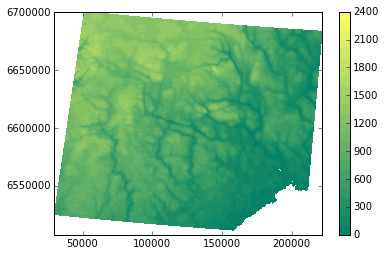

In [54]:
plt.contourf(x_telemark_utm33n, y_telemark_utm33n, z_telemark_utm33n, colors, cmap="summer")
plt.colorbar()

## Zoom alternative 2: Visual zoom 

[51690.6023793245, 209582.65692144883, 6506339.867251176, 6701252.498490713]

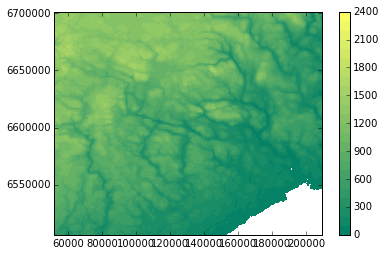

In [55]:
plt.contourf(x_utm33n, y_utm33n, z_utm33n, colors, cmap="summer")
plt.colorbar()

# zoom box
left_utm33n,  top_utm33n    = pyproj.transform(wgs84, utm33n, left,  top)
right_utm33n, bottom_utm33n = pyproj.transform(wgs84, utm33n, right, bottom)

plt.axis([left_utm33n, right_utm33n, bottom_utm33n, top_utm33n])

## Reproject samples to create new raster data with `rasterio.warp`

In [56]:
# Source information
west, east = x_1d[0], x_1d[-1]
north, south = y_1d[0], y_1d[-1]
src_transform = rasterio.transform.from_bounds(
    west, south, east, north,
    width,    height)
src_crs = {"init": "epsg:4326"}

print(z.shape)

# Destination information
height_telemark = i_bottom-i_top
width_telemark = i_right-i_left

dst_transform = rasterio.transform.from_bounds(
    left_utm33n,    bottom_utm33n,
    right_utm33n,   top_utm33n,
    width_telemark, height_telemark)
dst_crs = {"init": "epsg:32633"}

# container for output
z_reproject = np.empty((height_telemark, width_telemark), z.dtype)

print(z_reproject.shape)

(871, 1741)
(96, 186)


In [57]:
rasterio.warp.reproject(z, z_reproject,
          src_transform=src_transform, src_crs=src_crs,
          dst_transform=dst_transform, dst_crs=dst_crs,
          resampling=rasterio.warp.RESAMPLING.nearest)

## Mesh coordinates to new raster data

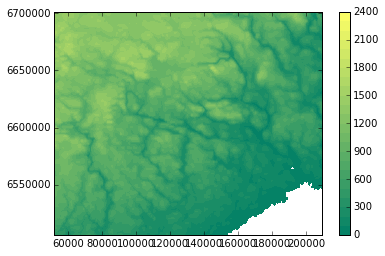

In [58]:
x_reproject = np.linspace(left_utm33n, right_utm33n, width_telemark)
y_reproject = np.linspace(top_utm33n, bottom_utm33n, height_telemark)

x_reproject, y_reproject = np.meshgrid(x_reproject, y_reproject)

plt.contourf(x_reproject, y_reproject, z_reproject, colors, cmap="summer")
plt.colorbar()

## Write new raster data to disk

In [43]:
with rasterio.open("telemark.nc", "w",
                   driver="netCDF",
                   crs={"init":"epsg:32633"}, transform=dst_transform,
                   width=width, height=height,
                   count=1, dtype=z_reproject.dtype
                  ) as dst:
    dst.write_band(1, z_reproject)

Save as raster file type without meta-info:

In [44]:
# rescale and recast
z_rescaled = (z_reproject - z_reproject.min()) / (z_reproject.max() - z_reproject.min()) * 255
z_rescaled = z_rescaled.astype(np.uint8)

# save as gif
with rasterio.open("telemark.gif", "w",
                   driver="gif", transform=dst_transform,
                   width=width, height=height,
                   count=1, dtype=np.uint8
                  ) as dst:
    dst.write_band(1, z_rescaled)

## Importing vector data using `fiona`

Read more on:
https://github.com/Toblerity/Fiona

Data from Norges vassdrags- og energidirektorat:
http://nedlasting.nve.no/gis/

In [46]:
src_shp = fiona.open("shp/Innsjo_InnsjoInformasjon.shp", "r")

print("File data type:")
print(src_shp.driver)
print()
print("Information about data:")
print(src_shp.schema)
print()
print("Coordinate reference system:")
print(src_shp.crs)

# Create local projection
proj_innsjo = pyproj.Proj(**src_shp.crs)

File data type:
ESRI Shapefile

Information about data:
{'geometry': '3D Point', 'properties': OrderedDict([('objType', 'str:32'), ('vatnLnr', 'float:11'), ('navn', 'str:35'), ('areal_km2', 'float:8.4'), ('arealNO', 'float:12.4'), ('hoyde_moh', 'float:11'), ('magasinNr', 'float:11'), ('vassdragNr', 'str:15'), ('hierarki', 'str:100'), ('dybdekart', 'str:1'), ('grensesjo', 'int:6'), ('land1', 'str:2'), ('land2', 'str:2'), ('vassOmrNr', 'str:3'), ('uttakDato', 'date'), ('ekspType', 'str:25')])}

Coordinate reference system:
{'units': 'm', 'no_defs': True, 'ellps': 'GRS80', 'proj': 'utm', 'zone': 33}


## Exploring the data content

In [17]:
print("Number of entries: %d" % len(src_shp))
print("First entry:")
print(src_shp[0])

Number of entries: 14659
First entry:
{'geometry': {'coordinates': (120430.72499999963, 6592609.6603125, 0.0), 'type': 'Point'}, 'type': 'Feature', 'id': '0', 'properties': OrderedDict([('objType', 'Innsjø'), ('vatnLnr', 14290.0), ('navn', 'Skredstøyltjørnan'), ('areal_km2', 0.0607), ('arealNO', 0.06), ('hoyde_moh', 801.0), ('magasinNr', None), ('vassdragNr', '019.F42AZ'), ('hierarki', 'GRIMDALSÅI/HORGEVIKÅI/ARENDALSVASSDRAGET'), ('dybdekart', None), ('grensesjo', None), ('land1', 'NO'), ('land2', None), ('vassOmrNr', '019'), ('uttakDato', '2016-01-19'), ('ekspType', 'NVEs nedlastningsløsning')])}


Cleaning up formating:
```
{
    'geometry' : {
               'type' : 'Point',
        'coordinates' : (120430.72499999963, 6592609.6603125, 0.0)
    },
    'properties' : {
            'objType' : 'Innsjø',
            'vatnLnr' : 14290.0,
               'navn' : 'Skredstøyltjørnan',
          'areal_km2' : 0.0607,
            'arealNO' : 0.06,
          'hoyde_moh' : 801.0,
          'magasinNr' : None,
         'vassdragNr' : '019.F42AZ',
           'hierarki' : 'GRIMDALSÅI/HORGEVIKÅI/ARENDALSVASSDRAGET',
          'dybdekart' : None,
          'grensesjo' : None,
              'land1' : 'NO',
              'land2' : None,
          'vassOmrNr' : '019',
          'uttakDato' : '2016-01-19',
           'ekspType' : 'NVEs nedlastningsløsning'
    }
    'type' : 'Feature',
    'id' : '0'
}
```

## Filter away unuseful properties

In [18]:
innsjo_large = []

for entry in src_shp:

    area = entry["properties"]["areal_km2"]
    
    if area > 20:
        innsjo_large.append(entry)

print("Antall innsjøer totalt: %d" % len(src_shp))
print("Antall store innsjøer: %d" % len(innsjo_large))

Antall innsjøer totalt: 14659
Antall store innsjøer: 10


## Extract the information of interest

In [19]:
innsjo_coords = []

for entry in innsjo_large:
    
    # retrieve polygon
    x, y, z = entry["geometry"]["coordinates"]

    # map sample to correct projection
    x, y = pyproj.transform(proj_innsjo, utm33n, x, y)
    
    innsjo_coords.append((x, y))

innsjo_coords = np.array(innsjo_coords)
print(innsjo_coords.shape)

(10, 2)


## Plot the data together with raster data

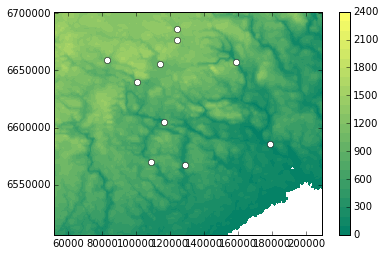

In [20]:
plt.contourf(x_reproject, y_reproject, z_reproject, colors, cmap="summer")
plt.colorbar()

for x,y in innsjo_coords:        
    plt.plot(x, y, "wo")

## Save changes to disk

In [21]:
with fiona.open("innsjo_large.shp", "w",
                driver=src_shp.driver,
                schema=src_shp.schema,
                crs=src_shp.crs
               ) as dst:

    for entry in innsjo_large:
        dst.write(entry)

## Import polygon vector data

Statens Kartverk provides data in `geojson` format fra:
http://data.kartverket.no/

In [22]:
src_gj = fiona.open("geojson/fylker.geojson", "r")

print("File data type:")
print(repr(src_gj.driver))
print()
print("Information about data:")
print(src_gj.schema)
print()
print("Coordinate reference system:")
print(src_gj.crs)

File data type:
'GeoJSON'

Information about data:
{'geometry': 'Polygon', 'properties': OrderedDict([('y', 'float'), ('poly_id', 'float'), ('area', 'float'), ('malemetode', 'int'), ('oppr', 'int'), ('objtype', 'str'), ('koordh', 'float'), ('h_malemeto', 'int'), ('max_avvik', 'int'), ('fylkesnr', 'int'), ('poly_', 'float'), ('x', 'float'), ('synbarhet', 'int'), ('noyaktighe', 'int'), ('navn', 'str'), ('perimeter', 'float'), ('h_noyaktig', 'int')])}

Coordinate reference system:
{'init': 'epsg:4326'}


Clearning up schema entry:
```
{
    'geometry' : 'Polygon',
    'properties' : {
                 'y' : 'float',
           'poly_id' : 'float',
              'area' : 'float',
        'malemetode' : 'int',
              'oppr' : 'int',
           'objtype' : 'str',
            'koordh' : 'float',
        'h_malemeto' : 'int',
         'max_avvik' : 'int',
           'fylkenr' : 'int',
             'poly_' : 'float',
                 'x' : 'float',
         'synbarhet' : 'int',
        'noyaktifhe' : 'int',
              'navn' : 'str',
         'parimeter' : 'float',
        'h_noyaktig' : 'int'
    }
}
```

In [23]:
# Same as above, but faster and no meta info
import json
with open("geojson/fylker.geojson", "r") as f:
    raw = f.read()
src_alt = json.loads(raw)["features"]

## Extract the border of Telemark

In [24]:
for feature in src_gj:
    if feature["properties"]["navn"] == "Telemark":
        break

border_coords = feature["geometry"]["coordinates"]

print("Number of polygons:")
print(len(border_coords))

border_coords = np.array(border_coords[0])
print("Polygon shape:")
print(border_coords.shape)

x_border, y_border = border_coords.T
x_border, y_border = pyproj.transform(wgs84, utm33n, x_border, y_border)

Number of polygons:
1
Polygon shape:
(7327, 2)


## Plot fylke border and fill fylke area

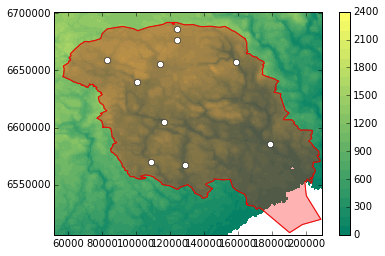

In [25]:
plt.contourf(x_reproject, y_reproject, z_reproject, colors, cmap="summer")
plt.colorbar()

plt.fill(x_border, y_border, "r", alpha=0.3)
plt.plot(x_border, y_border, "r")

for x,y in innsjo_coords:        
    plt.plot(x, y, "wo")

## Analysing data
For example: Find the large lake closest to fylke border.

In [26]:
x_innsjo, y_innsjo = innsjo_coords.T
print(x_border.shape, x_innsjo.shape)

(7327,) (10,)


## Meshing the data

In [27]:
x_innsjo_mesh, x_border_mesh = np.meshgrid(x_innsjo, x_border)
y_innsjo_mesh, y_border_mesh = np.meshgrid(y_innsjo, y_border)

print(x_innsjo_mesh.shape, x_border_mesh.shape)

(7327, 10) (7327, 10)


## Indetifying lake closest to border

In [59]:
def distance(x1, y1, x2, y2):
    return np.sqrt( (x1-x2)**2 + (y1-y2)**2 )

dist = distance(x_innsjo_mesh, y_innsjo_mesh, x_border_mesh, y_border_mesh)
dist_min = np.min(dist, 0)
print(dist_min)

index = np.argmin(dist_min)
print(index)

[  4509.33548035  31833.84809293   9269.91702462  13933.727331
  17158.24547126  11851.70119903  22940.71076653  31983.75023431
  18199.14506659  21464.76100655]
0


## Visualizing results

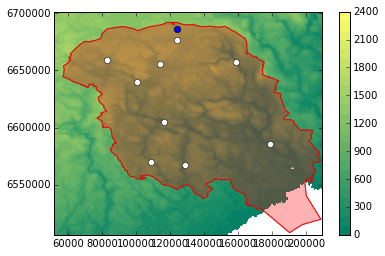

In [60]:
plt.contourf(x_reproject, y_reproject, z_reproject, colors, cmap="summer")
plt.colorbar()

plt.fill(x_border, y_border, "r", alpha=0.3)
plt.plot(x_border, y_border, "r")

for x,y in innsjo_coords:        
    plt.plot(x, y, "wo")

plt.plot(innsjo_coords[index, 0], innsjo_coords[index, 1], "bo")